In [980]:
# !pip install dowhy econml

In [981]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

import dowhy
from dowhy import CausalModel

In [982]:
SAMPLES_SIZE = 100000

In [983]:
# A Simple Data Set
G = nx.DiGraph()
G.add_edges_from([
    ('U', 'X'),
    ('U', 'Y'),
    ('X', 'Z'),
    ('Z', 'Y')
])

U = stats.truncnorm(-np.infty, np.infty, scale=4).rvs(SAMPLES_SIZE)
X = 0.7*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Z = -0.6*X + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Y = 0.7*Z + 0.25*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)

# QUESTION 1
# Using PATH method, what is the expected causal effect of X on Y?

In [984]:
# Try regular OLS
data = pd.DataFrame({'X': X, 'Z': Z})
data = sm.add_constant(data, prepend=True)
model = sm.OLS(Y, data) # Ordinary Linear Regression
results = model.fit()
results.summary()

# QUESTION 2
# What can you identify from this result in combination with the graph above

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                 2.709e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:10:46   Log-Likelihood:            -2.1529e+05
No. Observations:              100000   AIC:                         4.306e+05
Df Residuals:                   99997   BIC:                         4.306e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.007     -0.786      0.432      -0.018       0.008
X              0.2364      0.003     85.791      0.000       0.231       0.242
Z              0.6990      0.003    212.008      0.000       0.692       0.705
==============================================================================
Omnibus:                        1.990   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.995
Skew:                          -0.004   Prob(JB):                        0.369
Kurtosis:                       3.021   Cond. No.                         4.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
# Use DoWhy Model
model = CausalModel(
    data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z}),
    treatment='X',
    outcome='Y',
    graph="\n".join(nx.generate_gml(G))
)

1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


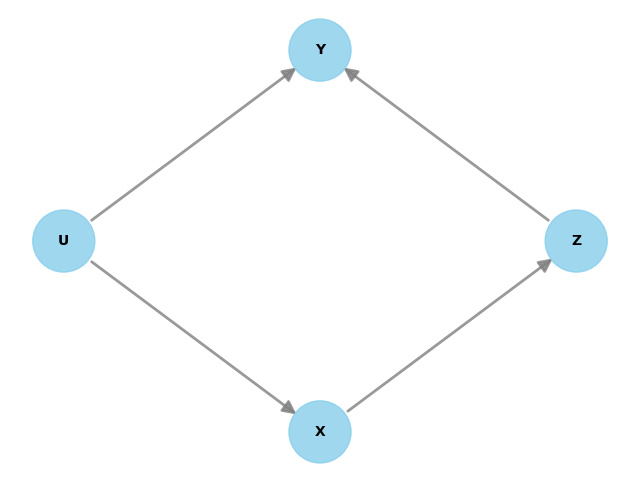

In [211]:
model.view_model()

In [212]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [213]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

# Question 3: Does this match your expection in Q1?

Estimate of causal effect (linear regression): -0.4215971053273499


In [214]:
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

In [215]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.4215971053273499
New effect:-0.42160186842688563
p value:0.98



In [216]:
refute_placebo = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="placebo_treatment_refuter")

In [217]:
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.4215971053273499
New effect:-0.42159710532734984
p value:0.0



In [218]:
# Another Data Set
G = nx.DiGraph()
G.add_edges_from([
    ('U', 'X'),
    ('U', 'Y'),
    ('X', 'Z'),
    ('Z', 'Y'),
    ('I', 'X')
])

U = stats.truncnorm(0, np.infty, scale=4).rvs(SAMPLES_SIZE)
I = stats.norm(scale=10).rvs(SAMPLES_SIZE)
X = 0.7*U + 0.3*I + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Z = -0.6*X + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Y = 0.7*Z + 0.25*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)

In [219]:
# Use DoWhy Model
model = CausalModel(
    data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z, 'U': U, 'I': I}),
    treatment='X',
    outcome='Y',
    graph="\n".join(nx.generate_gml(G))
)

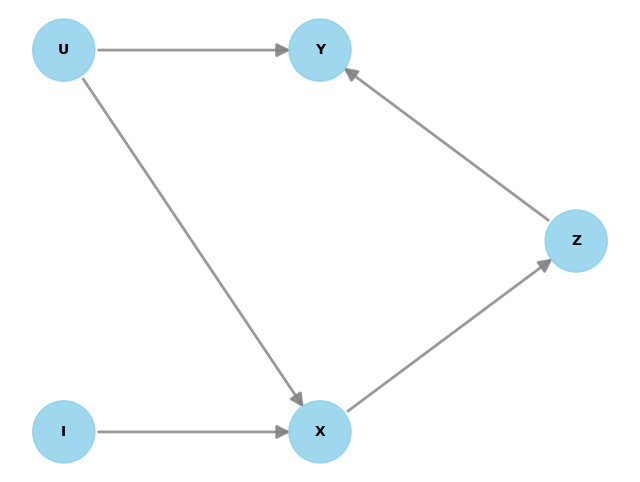

In [220]:
model.view_model()

In [221]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,U,U) = P(Y|X,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[I]    ⎝d[I]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{I})
Estimand assumption 2, Exclusion: If we remove {I}→{X}, then ¬({I}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [222]:
# No backdoor
data = pd.DataFrame({'X': X})
data = sm.add_constant(data, prepend=True)
model_ols_no_backdoor = sm.OLS(Y, data) # Ordinary Linear Regression
results = model_ols_no_backdoor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                 3.164e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        09:26:04   Log-Likelihood:            -2.3361e+05
No. Observations:              100000   AIC:                         4.672e+05
Df Residuals:                   99998   BIC:                         4.672e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6580      0.009     72.588      0.000       0.640       0.676
X             -0.3543      0.002   -177.887      0.000      -0.358      -0.350
==============================================================================
Omnibus:                        1.759   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.749
Skew:                           0.010   Prob(JB):                        0.417
Kurtosis:                       3.007   Cond. No.                         5.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
# Homegrown backdoor
data = pd.DataFrame({'X': X, 'U': U})
data = sm.add_constant(data, prepend=True)
model_ols_backdoor = sm.OLS(Y, data) # Ordinary Linear Regression
results = model_ols_backdoor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                 1.908e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        09:26:04   Log-Likelihood:            -2.3120e+05
No. Observations:              100000   AIC:                         4.624e+05
Df Residuals:                   99997   BIC:                         4.624e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.013      0.403      0.687      -0.020       0.030
X             -0.4183      0.002   -194.890      0.000      -0.423      -0.414
U              0.2493      0.004     70.375      0.000       0.242       0.256
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.035
Skew:                           0.001   Prob(JB):                        0.982
Kurtosis:                       2.998   Cond. No.                         9.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
estimate_backdoor = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect via backdoor (linear regression): {estimate_backdoor.value}')

# QUESTION 4 -- How are the difference between OLS No Backdoor, OLS Backdoor, and DoWhy Backdoor

Estimate of causal effect via backdoor (linear regression): -0.41830994715567127


In [225]:
refute_placebo = model.refute_estimate(
    estimand=estimand,
    estimate=estimate_backdoor,
    method_name="placebo_treatment_refuter")

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in sc

In [226]:
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.41830994715567127
New effect:0.0
p value:1.0



In [227]:
estimate_iv = model.estimate_effect(
    identified_estimand=estimand,
    method_name='iv.instrumental_variable')

print(f'Estimate of causal effect via IV: {estimate_iv.value}')

Estimate of causal effect via IV: -0.4195813417533689


In [228]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Estimate of causal effect (DML): -0.4176756347541162
